# Sentiment Analysis of Popular Vaccines

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

df = pd.read_csv('data/tweet_sentiment.csv', names=['vaccine', 'tweet', 'location', 'verified', 'language', 
                                                    'follower', 'sentiment'], low_memory=False)
df['vaccine'].unique()

array(['Pfizer BioNTech', 'Moderna', 'AstraZeneca', 'Sputnik V',
       'Johnson & Johnson', 'EpiVacCorona', 'BBIBP-CorV', 'Sputnik Light',
       'Convidicea', 'CoronaVac', 'Covaxin'], dtype=object)

# 1. Dataset Analysis

## 1.1. Overall Dataset

sentiment,-1,0,1
tweet,29664,84104,52993


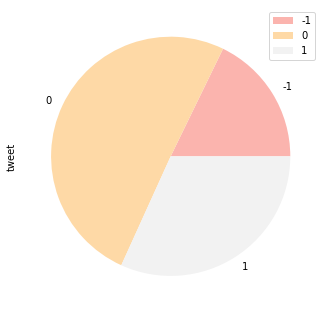

In [64]:
display(df[["tweet", "sentiment"]].groupby(['sentiment']).count().transpose())
df[["tweet", "sentiment"]].groupby(['sentiment']).count().plot.pie(y='tweet', cmap="Pastel1", figsize=(5.5,5.5))
plt.plot()
plt.savefig("sentiment_dist.svg", format="svg")

## 1.2. Language Targeted Analysis

In [4]:
display(df[['location', 'language']].dropna().groupby(['language'])['location'].unique())

language
de    [Germany, United States, Austria, Switzerland,...
en    [United States, Singapore, Canada, Japan, Arge...
fr    [France, United States, Tunisia, Morocco, Cana...
Name: location, dtype: object

**Tweets from a language does not come from any specific country.** For example a Tweet in French might come from Tunisia not only from France.

In [5]:
df[["tweet","language"]].groupby(['language']).count().transpose()

language,de,en,fr
tweet,4614,158803,3344


In [6]:
lang_and_sents = df[["tweet", "sentiment","language"]].groupby(['language', 'sentiment']).count()
lang_and_sents.T

language    de                en                 fr            
sentiment   -1     0    1     -1      0      1   -1     0     1
tweet      376  3537  701  29033  79522  50248  255  1045  2044

In [7]:
lang_and_tweets = df[['language','tweet']].groupby('language').count()
lang_norm_sents = lang_and_sents.div(lang_and_tweets, axis=1).apply(lambda x: x*100)

lang_norm_sents.reset_index(inplace=True)

lang_norm_pos = lang_norm_sents[lang_norm_sents['sentiment'] == 1].drop(['sentiment'], axis=1)
lang_norm_neg = lang_norm_sents[lang_norm_sents['sentiment'] == -1].drop(['sentiment'], axis=1)
lang_norm_neutral = lang_norm_sents[lang_norm_sents['sentiment'] == 0].drop(['sentiment'], axis=1)

lang_norm_pn = lang_norm_pos.join(lang_norm_neutral.set_index('language'), on='language', 
                                           how='left', lsuffix='_left', rsuffix='_right')

lang_norm_pn.rename(columns={"tweet_left": "positive", "tweet_right": "neutral"}, inplace=True)

lang_norm_total = lang_norm_pn.join(lang_norm_neg.set_index('language'), on='language', how='left')

lang_norm_total.rename(columns={"tweet":"negetive"}, inplace=True)
lang_norm_total.set_index('language', inplace=True)
lang_norm_total

,positive,neutral,negetive
language,,,
de,15.192891,76.657997,8.149111
en,31.641720,50.075880,18.282400
fr,61.124402,31.250000,7.625598


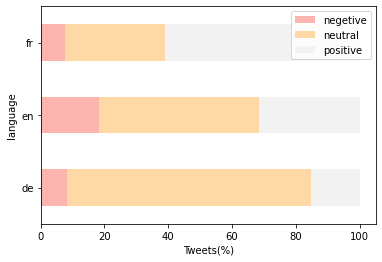

In [26]:
lang_norm_total[["negetive","neutral", "positive"]].plot(kind='barh', stacked=True, cmap='Pastel1')
plt.xlabel('Tweets(%)')
plt.plot()
#plt.savefig("lang_sentiment.svg",  format="svg")

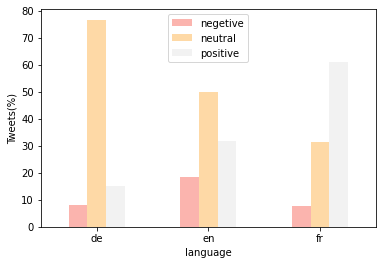

In [25]:
lang_norm_total[["negetive","neutral", "positive"]].plot(kind='bar', cmap='Pastel1', rot=0)
plt.ylabel('Tweets(%)')
plt.plot()
#plt.savefig("lang_sentiment_2.svg",  format="svg")

## 1.3. Account Targeted Analysis

In [10]:
df[["tweet", "sentiment","verified"]].groupby(['verified', 'sentiment']).count().transpose()

verified   False               True             
sentiment     -1      0      1    -1     0     1
tweet      27192  75671  47861  2472  8433  5132

In [11]:
verified_sentiment = df[["tweet", "sentiment", "verified"]].groupby(['verified']).mean()
display(verified_sentiment)
print(verified_sentiment[['sentiment']].iloc[1]/verified_sentiment[['sentiment']].iloc[0])

,sentiment
verified,
False,0.137131
True,0.165866


sentiment    1.209543
dtype: float64


The blue verified badge on Twitter lets people know that an account of public interest is authentic. **A verified user is on an average $\approx1.5$ times more likely to have a positive sentiment about any vaccine.**

## 1.4. Country Targeted Analysis

In [12]:
loc_and_sents = df[["tweet", "sentiment","location"]].groupby(['location', 'sentiment']).count()

loc_and_tweets = df[['location','tweet']].groupby('location').count()
loc_norm_sents = loc_and_sents.div(loc_and_tweets, axis=1).apply(lambda x: x*100)

loc_norm_sents.reset_index(inplace=True)

loc_norm_pos = loc_norm_sents[loc_norm_sents['sentiment'] == 1].drop(['sentiment'], axis=1)
loc_norm_neg = loc_norm_sents[loc_norm_sents['sentiment'] == -1].drop(['sentiment'], axis=1)
loc_norm_neutral = loc_norm_sents[loc_norm_sents['sentiment'] == 0].drop(['sentiment'], axis=1)

loc_norm_pn = loc_norm_pos.join(loc_norm_neutral.set_index('location'), on='location', 
                                           how='left', lsuffix='_left', rsuffix='_right')

loc_norm_pn.rename(columns={"tweet_left": "positive", "tweet_right": "neutral"}, inplace=True)

loc_norm_total = loc_norm_pn.join(loc_norm_neg.set_index('location'), on='location', how='left')

loc_norm_total.rename(columns={"tweet":"negetive"}, inplace=True)
loc_norm_total.set_index('location', inplace=True)
loc_norm_total.dropna(inplace=True)

loc_norm_total.sort_values(by=['negetive'], ascending=False).head()

,positive,neutral,negetive
location,,,
"Palestinian Territory, Occupied",11.111111,22.222222,66.666667
Belarus,28.571429,14.285714,57.142857
Haiti,25.000000,25.000000,50.000000
Macao,28.571429,28.571429,42.857143
Denmark,25.563910,32.330827,42.105263


### 1.4.1. Heatmap of Countries with Negetive Sentiment About Vaccine

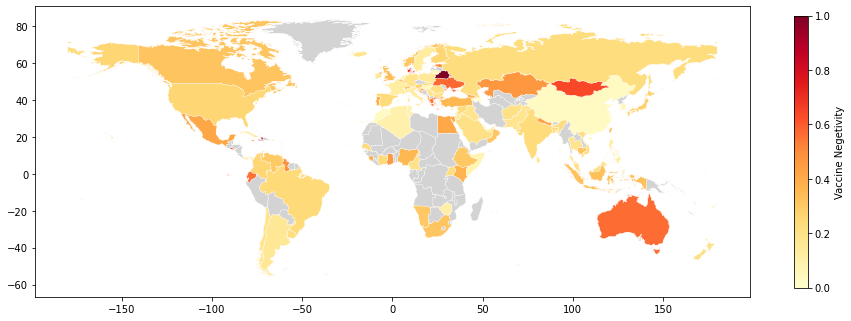

In [28]:
def normalize(df, feature_name):
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        df[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return df




world_map = gpd.read_file(r'data/World_Map/World_Map.shp')

world_map_sent = world_map.set_index('NAME').join(loc_norm_total.reset_index().rename(columns= 
                                        {'location':'NAME'}).set_index('NAME'), how='left', on='NAME').reset_index()

world_map_neg = normalize(world_map_sent, 'negetive')
world_map_neg.plot(column='negetive', cmap="YlOrRd", figsize=(16,10), legend=True, missing_kwds={'color': 'lightgrey'},
                  legend_kwds={'label': "Vaccine Negetivity",'shrink': 0.5}, 
                    edgecolor='white', linewidth = 0.3)
plt.plot()
#plt.savefig("map_neg.svg", format="svg")

### 1.4.2. Heatmap of Countries with Positive Sentiment About Vaccine

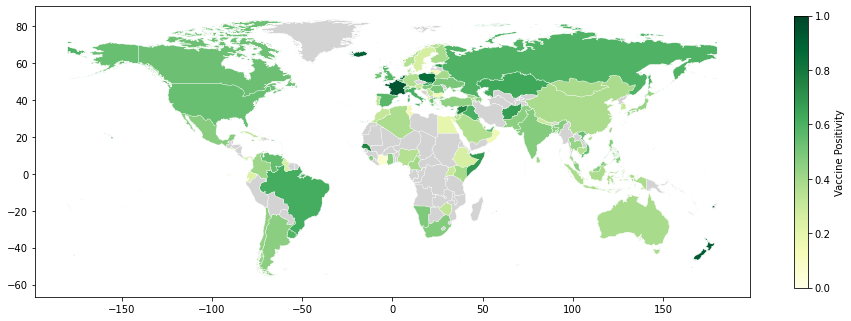

In [29]:
world_map_pos = normalize(world_map_sent, 'positive')
world_map_pos.plot(column='positive', cmap="YlGn", figsize=(16,10), legend=True, missing_kwds={'color': 'lightgrey'},
                  legend_kwds={'label': "Vaccine Positivity",'shrink': 0.5}, 
                    edgecolor='white', linewidth = 0.3)
plt.plot()
#plt.savefig("map_pos.svg", format="svg")

## 1.5. Individual Vaccine Targeted Analysis

In [30]:
vaccines_and_sents = df[['vaccine','sentiment', 'tweet']].groupby(['vaccine','sentiment']).count()
vaccines_and_sents.head()

tweet
vaccine     sentiment       
AstraZeneca -1          2820
             0          6408
             1          3949
BBIBP-CorV  -1          1097
             0          3683

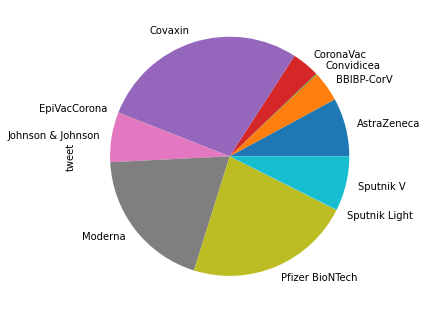

In [31]:
vaccine_and_tweets = df[['vaccine','tweet']].groupby('vaccine').count()
vaccine_and_tweets['fraction of data'] = vaccine_and_tweets['tweet']/vaccine_and_tweets.sum()[0]
vaccine_and_tweets.plot.pie(y='tweet', cmap="tab10", figsize=(5.5,5.5), legend=False)
plt.plot()
plt.savefig("Vaccine Distribution.svg", format='svg')

In [32]:
vaccine_norm_sent = vaccines_and_sents.div(vaccine_and_tweets, axis=1).apply(lambda x: x*100).drop(['fraction of data'], 
                                                                                                  axis=1).reset_index()
vaccine_norm_pos = vaccine_norm_sent[vaccine_norm_sent['sentiment'] == 1].drop(['sentiment'], axis=1)
vaccine_norm_neg = vaccine_norm_sent[vaccine_norm_sent['sentiment'] == -1].drop(['sentiment'], axis=1)
vaccine_norm_neu = vaccine_norm_sent[vaccine_norm_sent['sentiment'] == 0].drop(['sentiment'], axis=1)

vaccine_norm_pn = vaccine_norm_pos.join(vaccine_norm_neu.set_index('vaccine'), on='vaccine', 
                                           how='left', lsuffix='_left', rsuffix='_right')

vaccine_norm_pn.rename(columns={"tweet_left": "positive", "tweet_right": "neutral"}, inplace=True)

vaccine_norm_total = vaccine_norm_pn.join(vaccine_norm_neg.set_index('vaccine'), on='vaccine', how='left')
vaccine_norm_total.rename(columns={"tweet":"negetive"}, inplace=True)
vaccine_norm_total.set_index('vaccine', inplace=True)
print(vaccine_norm_total)

                    positive    neutral   negetive
vaccine                                           
AstraZeneca        29.968885  48.630189  21.400926
BBIBP-CorV         30.391729  53.633319  15.974953
Convidicea         24.365482  63.959391  11.675127
CoronaVac          30.068921  47.187049  22.744029
Covaxin            23.631830  63.583667  12.784503
EpiVacCorona       19.047619  59.523810  21.428571
Johnson & Johnson  35.209132  39.516632  25.274235
Moderna            37.712323  42.873055  19.414622
Pfizer BioNTech    35.577386  45.235291  19.187323
Sputnik Light      30.303030  50.000000  19.696970
Sputnik V          36.411136  47.383460  16.205405


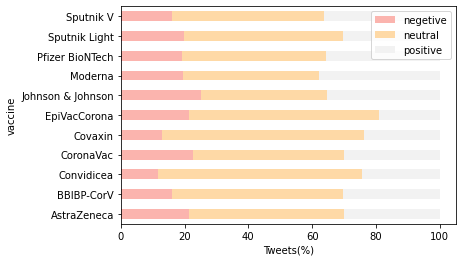

In [33]:
vaccine_norm_total[["negetive","neutral", "positive"]].plot(kind='barh', stacked=True, cmap='Pastel1')
plt.xlabel('Tweets(%)')
plt.plot()
plt.savefig("vaccine_sentiment_stacked.svg", format='svg')

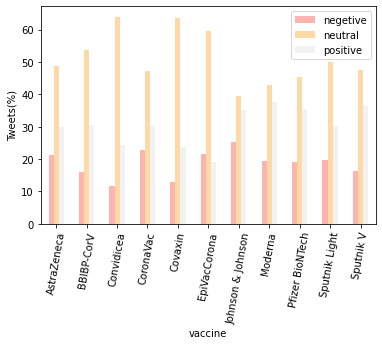

In [34]:
vaccine_norm_total[["negetive","neutral", "positive"]].plot(kind='bar', cmap='Pastel1', rot=80)
plt.ylabel('Tweets(%)') 
plt.plot()
plt.savefig("vaccine_sentiment_bar.svg", format='svg')

### 1.5.1. Favourite Vaccine of Each Country

In [71]:
cntry_vac_sent = df[['vaccine', 'location', 'sentiment', 'tweet']].groupby(['location', 'vaccine', 'sentiment']).count()
cntry_vac_sent.reset_index(inplace=True)
cntry_vac_sent.set_index(['location', 'vaccine'], inplace=True)

dropped = 0
for index, row in cntry_vac_sent.iterrows():
    if row['tweet'] < 10:
        try:
            cntry_vac_sent.drop(index, inplace=True)
            dropped += row['tweet']
            
        except:
            pass

cntry_vac_sent.reset_index(inplace=True)
cntry_vac_sent.set_index(['location', 'vaccine', 'sentiment'], inplace=True)
display(cntry_vac_sent.head())
print(dropped)

tweet
location  vaccine           sentiment       
Australia AstraZeneca       -1            77
                             0            83
                             1            59
          Johnson & Johnson -1            26
                             0            22

2065


In [74]:
cntry_vac_sent_tot = df[['vaccine', 'location', 'tweet']].groupby(['location', 'vaccine']).count()

cntry_vac_sent_norm = cntry_vac_sent.div(cntry_vac_sent_tot, axis=1).reset_index()

cntry_vac_sent_pos = cntry_vac_sent_norm[cntry_vac_sent_norm['sentiment'] == 1].drop(['sentiment'], axis=1)
cntry_vac_sent_neu = cntry_vac_sent_norm[cntry_vac_sent_norm['sentiment'] == 0].drop(['sentiment'], axis=1)

cntry_vac_sent_nupo = cntry_vac_sent_pos.set_index(['location','vaccine']).join(cntry_vac_sent_neu.set_index(
                                                    ['location', 'vaccine']), on=['location', 'vaccine'],
                                                        how='outer', lsuffix='_left', rsuffix='_right').fillna(0)

cntry_vac_sent_nupo['natural_like'] = cntry_vac_sent_nupo['tweet_left'] + cntry_vac_sent_nupo['tweet_right']

cntry_vac_sent_nupo.drop(columns=['tweet_left', 'tweet_right'], axis=1, inplace=True)
cntry_vac_sent_nupo.reset_index(inplace=True)

cond_prob = list()

# Apply Bay's Theorem to calculate conditional Probability
for vaccine in cntry_vac_sent_nupo['vaccine']:
    cond_prob.append(cntry_vac_sent_nupo['natural_like'][0]*vaccine_and_tweets.loc[vaccine]['fraction of data'])
            
cntry_vac_sent_nupo['likelihood'] = np.array(cond_prob)
cntry_vac_sent_nupo.set_index(['location', 'vaccine'], inplace=True)
cntry_vac_sent_nupo.drop(columns=['natural_like'], inplace=True)
display(cntry_vac_sent_nupo.head())

likelihood
location  vaccine                      
Australia AstraZeneca          0.051235
          Johnson & Johnson    0.043599
          Moderna              0.125671
          Pfizer BioNTech      0.145256
Austria   Sputnik V            0.047627

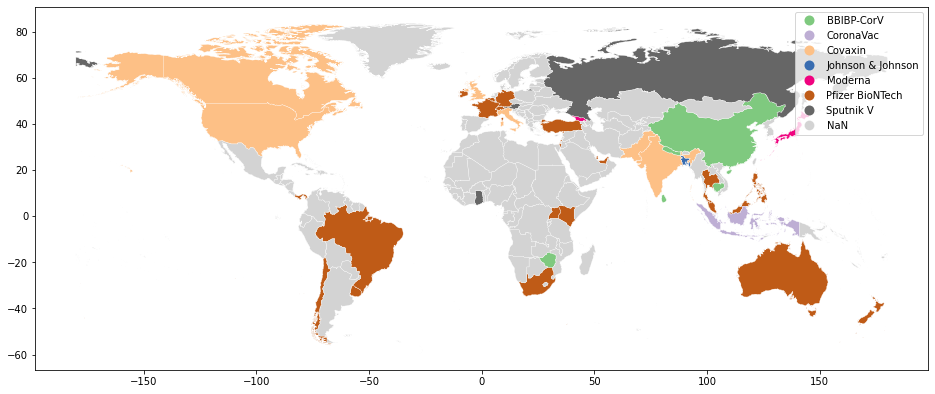

In [75]:
cntry_fav_vaccine = pd.DataFrame(columns=['NAME', 'Favourite Vaccine'])

for _, new_df in cntry_vac_sent_nupo.groupby(level=0):
    cntry_fav_vaccine.loc[len(cntry_fav_vaccine)] = new_df.idxmax()[0]
    
wld_map_fav_vacc = world_map.set_index('NAME').join(cntry_fav_vaccine.set_index('NAME'), how='left', on='NAME')

wld_map_fav_vacc.plot(column='Favourite Vaccine', cmap='Accent', figsize=(16,10), legend=True,
                      missing_kwds={'color': 'lightgrey'}, edgecolor='white', linewidth = 0.3)
plt.plot()
plt.savefig("counrty_fav_vaccine.svg", format='svg')